In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam

In [ ]:
df = pd.read_excel('/content/Data.xlsx')

In [ ]:
# First five lines of the Dataframe
df.head()

,Date,DMI,NINO,NOA,PDO,SOI,TP
0,1951-01-01,2.170837,25.24,0.08,-1.19,1.5,55.273902
1,1951-02-01,2.882812,25.71,0.70,-1.52,0.9,7.121963
2,1951-03-01,1.829071,26.90,-1.02,-1.72,-0.1,172.638707
3,1951-04-01,1.841797,27.58,-0.22,-1.35,-0.3,76.846350
4,1951-05-01,-0.148438,27.92,-0.59,-1.29,-0.7,91.090277


In [ ]:
data =df['TP'].values

In [ ]:
df['Date'] = pd.to_datetime(df['Date'])
df = df.set_index('Date')

In [ ]:
# Ensures that all values are within the [0, 1] range after scaling.
scaler = StandardScaler()
data = scaler.fit_transform(data.reshape(-1, 1))

In [ ]:
def create_sequences(data, sequence_length):
    sequences = []  # List to store the input sequences
    targets = []    # List to store the corresponding target values

    for i in range(len(data) - sequence_length):
        # Extracts a sequence of data with the specified length
        sequence = data[i:i + sequence_length]

        # Extracts the target value, which is the value immediately following the sequence
        target = data[i + sequence_length]

        # Appends the sequence and target to the respective lists
        sequences.append(sequence)
        targets.append(target)

    # Converts the lists to NumPy arrays for efficient processing
    return np.array(sequences), np.array(targets)


In [ ]:
# Determines the number of previous time steps (or data points) considered when creating input sequences
sequence_length = 20

# Represents the size of the training dataset
train_size = int(0.8 * len(data))

In [ ]:
# Creates input sequences and corresponding target values from the data.
X, y = create_sequences(data, sequence_length)

# Splits the input sequences and target values into training and testing sets.
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

In [ ]:
# Create a sequential model
model = Sequential()

# Add the first LSTM layer with 100 units, specifying input shape for time-series data
# and return_sequences=True to stack LSTM layers
model.add(LSTM(100, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True))

# Add a dropout layer to prevent overfitting (20% of neurons will be dropped during training)
model.add(Dropout(0.2))

# Add the second LSTM layer with 100 units
model.add(LSTM(100))

# Add another dropout layer
model.add(Dropout(0.2))

# Add a dense (fully connected) layer with a single output neuron
model.add(Dense(1))

# Compile the model with the Adam optimizer and mean squared error loss function
model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')

In [ ]:
# Training the model
model.fit(X_train, y_train, epochs=100, batch_size=64, validation_data=(X_test, y_test), verbose=1)

Epoch 1/100
11/11 [==============================] - 8s 181ms/step - loss: 0.8735 - val_loss: 1.1154
Epoch 2/100
11/11 [==============================] - 1s 81ms/step - loss: 0.7674 - val_loss: 1.0100
Epoch 3/100
11/11 [==============================] - 1s 79ms/step - loss: 0.5915 - val_loss: 0.7161
Epoch 4/100
11/11 [==============================] - 1s 81ms/step - loss: 0.4756 - val_loss: 0.6634
Epoch 5/100
11/11 [==============================] - 1s 79ms/step - loss: 0.4459 - val_loss: 0.5840
Epoch 6/100
11/11 [==============================] - 1s 78ms/step - loss: 0.4757 - val_loss: 0.6441
Epoch 7/100
11/11 [==============================] - 1s 79ms/step - loss: 0.4426 - val_loss: 0.5991
Epoch 8/100
11/11 [==============================] - 1s 79ms/step - loss: 0.4204 - val_loss: 0.5763
Epoch 9/100
11/11 [==============================] - 1s 138ms/step - loss: 0.4213 - val_loss: 0.5598
Epoch 10/100
11/11 [==============================] - 2s 156ms/step - loss: 0.4253 - val_loss: 0.5

In [ ]:
# Make predictions on the training data using the trained model
train_predict = model.predict(X_train)

# Make predictions on the testing data using the trained model
test_predict = model.predict(X_test)

5/5 [==============================] - 0s 12ms/step


In [ ]:
# Inverse transforms the scaled predictions to the original data scale for training predictions
train_predict = scaler.inverse_transform(train_predict)

# Inverse transforms the scaled predictions to the original data scale for testing predictions
test_predict = scaler.inverse_transform(test_predict)

In [ ]:
# Root Mean Squared Error (RMSE) between the actual Total Precipitation (TP) values
test_rmse = np.sqrt(mean_squared_error(df['TP'].values[train_size + sequence_length:], test_predict))
test_rmse

68.88423595113768

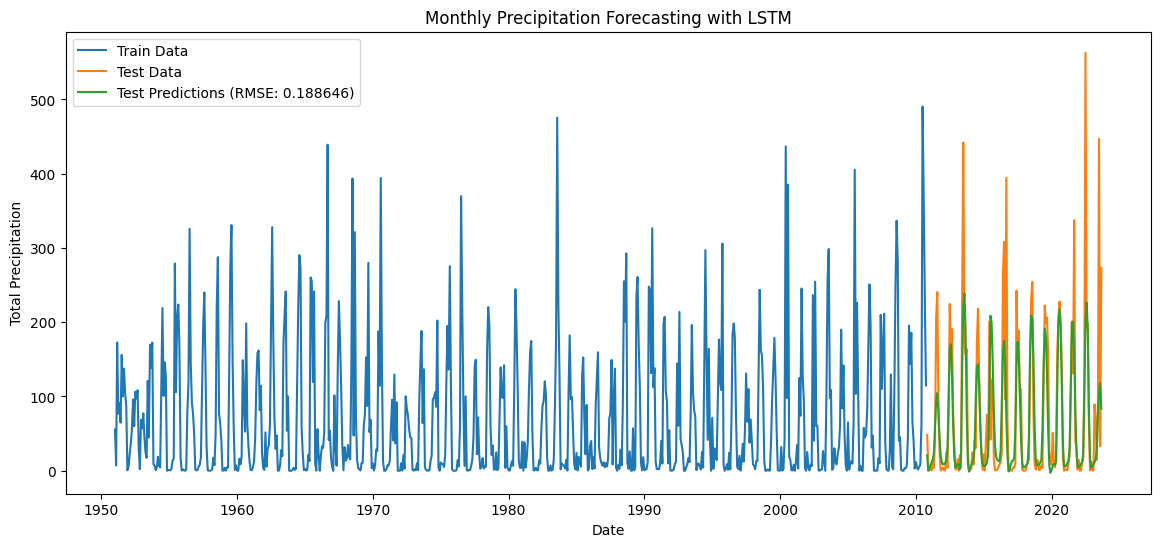

In [ ]:
# Graph including training data, test data and predicted values for the test data
plt.figure(figsize=(14, 6))
plt.plot(df.index[:train_size+sequence_length], df['TP'][:train_size+sequence_length], label='Train Data')
plt.plot(df.index[train_size+sequence_length:], df['TP'][train_size+sequence_length:], label='Test Data')
plt.plot(df.index[train_size+sequence_length:], test_predict, label=f'Test Predictions (RMSE: 0.188646)')
plt.legend()
plt.xlabel('Date')
plt.ylabel('Total Precipitation')
plt.title('Monthly Precipitation Forecasting with LSTM')
plt.show()

In [ ]:
# Creates a future sequence by selecting the last sequence length data points from the data
future_sequence = data[-sequence_length:]
future_predictions = []

In [ ]:
for _ in range(12):
    # Make a prediction for the next time step using the current future_sequence
    next_step = model.predict(future_sequence.reshape(1, sequence_length, 1))

    # Append the predicted value to the future_predictions list
    future_predictions.append(next_step[0, 0])

    # Update the future_sequence for the next iteration
    future_sequence = np.append(future_sequence[1:], next_step, axis=0)

1/1 [==============================] - 0s 30ms/step


In [ ]:
from datetime import datetime, timedelta

# Define the start date (one month after the last date in your original dataset)
start_date = df.index[-1] + pd.DateOffset(months=1)

# Define the end date (5 months from the start date)
end_date = start_date + pd.DateOffset(months=11)

# Generate the date range
date_range = pd.date_range(start=start_date, end=end_date, freq='MS')  # 'MS' means month start

# Create a DataFrame with the date range
future_data = pd.DataFrame({'Date': date_range})

# You can add placeholder values for other columns if needed
future_data['DMI'] = np.nan
future_data['NINO'] = np.nan
future_data['NOA'] = np.nan
future_data['PDO'] = np.nan
future_data['SOI'] = np.nan

# Set the 'Date' column as the index
future_data.set_index('Date', inplace=True)

In [ ]:
future_predictions = scaler.inverse_transform(np.array(future_predictions).reshape(-1, 1))

In [ ]:
# Flatten the two-dimensional future_predictions array
future_predictions_flat = future_predictions.flatten()

# Create the "future" DataFrame
future = pd.DataFrame({'Date': date_range, 'Predicted Total Precipitation': future_predictions_flat})

In [ ]:
date_range.shape

(12,)

In [ ]:
future_predictions_flat.shape

(12,)

<ipython-input-23-aebf0f8547ff>:3: FutureWarning: Argument `closed` is deprecated in favor of `inclusive`.
  plt.plot(pd.date_range(end=end_date, periods=12, closed='right'), future_predictions, label='Future Predictions')


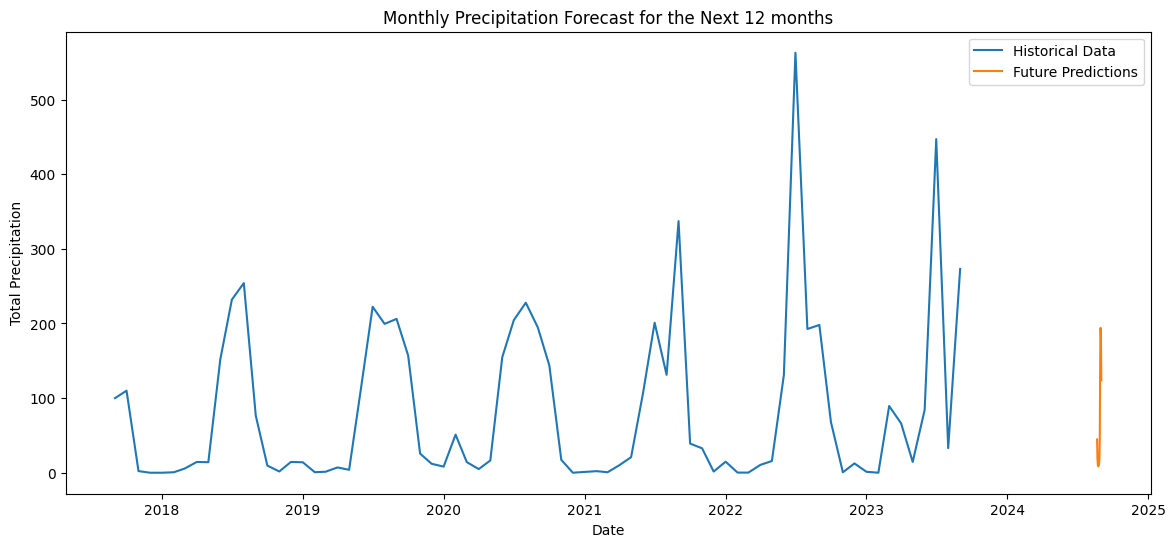

In [ ]:
plt.figure(figsize=(14, 6))
plt.plot(df.index[800:], df['TP'][800:], label='Historical Data')
plt.plot(pd.date_range(end=end_date, periods=12, closed='right'), future_predictions, label='Future Predictions')
plt.legend()
plt.xlabel('Date')
plt.ylabel('Total Precipitation')
plt.title('Monthly Precipitation Forecast for the Next 12 months')
plt.show()

In [ ]:
future

,Date,Predicted Total Precipitation
0,2023-10-01,44.623600
1,2023-11-01,19.037258
2,2023-12-01,9.919217
3,2024-01-01,8.428147
4,2024-02-01,9.396337
5,2024-03-01,12.206437
6,2024-04-01,17.627377
7,2024-05-01,48.022446
8,2024-06-01,151.361313
9,2024-07-01,194.136124


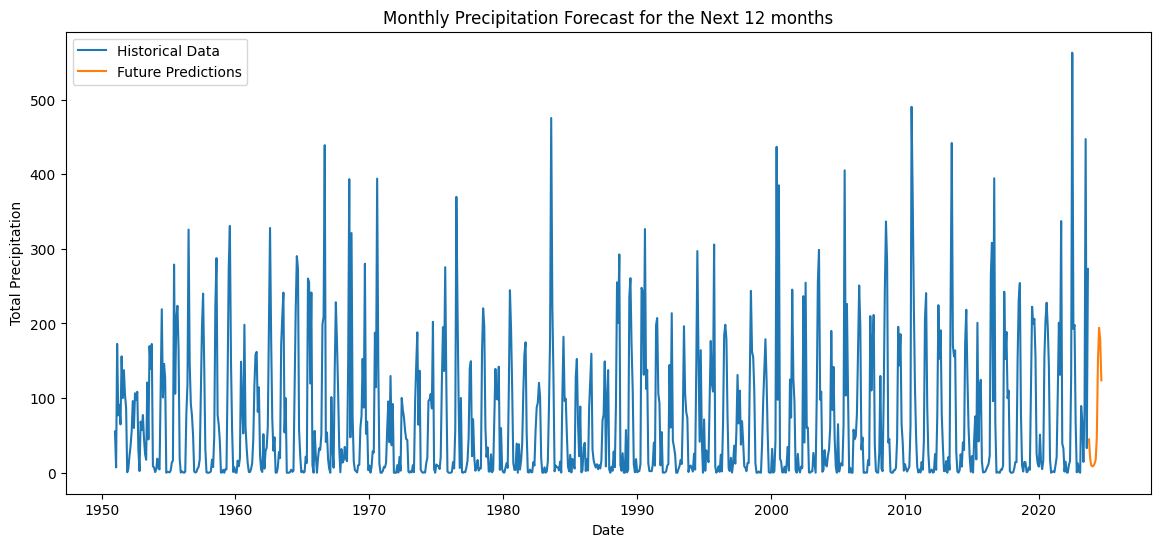

In [ ]:
plt.figure(figsize=(14, 6))
plt.plot(df.index, df['TP'], label='Historical Data')
plt.plot(future['Date'], future['Predicted Total Precipitation'], label='Future Predictions')
plt.legend()
plt.xlabel('Date')
plt.ylabel('Total Precipitation')
plt.title('Monthly Precipitation Forecast for the Next 12 months')
plt.show()

In [ ]:
test_rmse

68.88423595113768